In [ ]:
import os
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')
# Provide the path to the folder in your Drive
folder_path = '/content/drive/MyDrive/CCFD_Delivery/Data'
os.chdir(folder_path)
os.listdir()

Mounted at /content/drive


['pipeline_utils.py',
 'creditcard.csv',
 'resampled_data.pkl',
 '__pycache__',
 'resampled_data_new.pkl',
 'exps',
 'resampled_data_nb2.pkl',
 'Sampling_Time_nb2.csv',
 'class1_f1_score_plot.png',
 'class1_f1_score_plot_nb4.png',
 'classification_cost_plot_nb4.png',
 'Training_time_nb4.csv',
 'performance_metrics_plot.png']

In [ ]:
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pipeline_utils import scale_data, split_data
from imblearn.under_sampling import ClusterCentroids, TomekLinks
from imblearn.over_sampling import ADASYN, SVMSMOTE, BorderlineSMOTE
from sklearn.feature_selection import SelectKBest, mutual_info_classif

## Loading Data, Scaling

In [ ]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df = data.copy()
scale_data(df, cols = ['Amount', 'Time'])
df

,scaled_Amount,scaled_Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-0.296653,1.034951,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0
284803,0.038986,1.034963,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0
284804,0.641096,1.034975,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0
284805,-0.167680,1.034975,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0


## Feature Selection (MI Score)

In [ ]:
def select_best_features(data, target_column, k):
    X = data.drop(columns=[target_column])
    y = data[target_column]

    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    selector.fit(X, y)

    selected_indices = selector.get_support(indices=True)
    selected_feature_names = list(X.columns[selected_indices])

    return selected_feature_names

In [ ]:
selected_features = select_best_features(df, 'Class', 20)
print(f"Select Features: {selected_features}")
new_df = df[selected_features]

Select Features: ['scaled_Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V21', 'V27', 'V28']


In [ ]:
X_train, X_test, y_train, y_test = split_data(df, 0.2)

(284807, 30)
(284807, 1)

 Train set
[0 1]
[227451    394]
[99.82707542  0.17292458] %

 Test set
[0 1]
[56864    98]
[99.82795548  0.17204452] %


## Sampling

In [ ]:
samplers = {
    "ADASYN": ADASYN(random_state=42),
    "SVMSMOTE": SVMSMOTE(random_state=42),
    "BorderlineSmote": BorderlineSMOTE(sampling_strategy='auto' ,random_state=42),
    "ClusterCentroids": ClusterCentroids(random_state=42),
    "TomekLinks" : TomekLinks()
}

In [ ]:
# Dictionary to hold the resampled data
resampled_data = {}
results_df = pd.DataFrame(columns=["Sampler", "Sampling_Time"])

for sampler_name, sampler in samplers.items():
    print('\t' + sampler_name)
    start_time = time.time()
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)  # Resample X_train and y_train
    end_time = time.time()
    print(f"{sampler_name} Done!")

    # Append the results to the DataFrame using pd.concat
    new_row = {"Sampler": sampler_name, "Sampling_Time": end_time - start_time}
    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

    # Store the resampled data in the dictionary
    resampled_data[f"X_resampled_{sampler_name}"] = X_resampled
    resampled_data[f"y_resampled_{sampler_name}"] = y_resampled

print(results_df)

	ADASYN
ADASYN Done!
	SVMSMOTE
SVMSMOTE Done!
	BorderlineSmote
BorderlineSmote Done!
	ClusterCentroids


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ClusterCentroids Done!
	TomekLinks
TomekLinks Done!
            Sampler  Sampling_Time
0            ADASYN       1.334611
1          SVMSMOTE     224.563625
2   BorderlineSmote       1.206708
3  ClusterCentroids     639.491280
4        TomekLinks     359.132806


In [ ]:

#Saving the Sampling Time DF
results_df.to_csv("Sampling_Time_nb2.csv")

## Saving Data in Pickle File

In [ ]:
# Add X_train and y_train to the resampled_data dictionary for later use
resampled_data["X_train"] = X_train
resampled_data["y_train"] = y_train

# Add X_test and y_test to the resampled_data dictionary for later use
resampled_data["X_test"] = X_test
resampled_data["y_test"] = y_test

#Saving dictionary in pickle file
with open("resampled_data_nb2.pkl", "wb") as f:
    pickle.dump(resampled_data, f)

## Loading Pickle File

In [ ]:
#Loading the pickle file
with open("resampled_data_nb2.pkl", "rb") as f:
  resampled_data = pickle.load(f)

resampled_data.keys()

dict_keys(['X_resampled_ADASYN', 'y_resampled_ADASYN', 'X_resampled_SVMSMOTE', 'y_resampled_SVMSMOTE', 'X_resampled_BorderlineSmote', 'y_resampled_BorderlineSmote', 'X_resampled_ClusterCentroids', 'y_resampled_ClusterCentroids', 'X_resampled_TomekLinks', 'y_resampled_TomekLinks', 'X_train', 'y_train', 'X_test', 'y_test'])

In [ ]:
X_train = resampled_data['X_train']
y_train = resampled_data['y_train']

## Plotting Data Distribution Before and After

In [ ]:
# This Function Plots a dot plot of the classes distribution with all the features
def plot_dot_plot(X_train, y_train):
    num_features = X_train.shape[1]
    num_classes = len(np.unique(y_train))

    fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(6, 4*num_features))

    for i in range(num_features):
        ax = axes[i]
        feature_values = X_train[:, i]
        ax.scatter(feature_values, y_train, alpha=0.5)
        ax.set_xlabel(f'Feature {i+1}')
        ax.set_ylabel('Class Label')
        ax.set_title(f'Dot Plot for Feature {i+1}')

    plt.tight_layout()
    plt.show()

In [ ]:
# This function plots class distribution for all samplers, it takes one argument (The dictionary that contains all the resampled data)
def data_distribution_all_samplers(resampled_data):
    plt.figure(figsize=(10, 6))
    width = 0.35  # Width of the bars

    samplers = []
    class_0_counts = []
    class_1_counts = []

    for key in resampled_data.keys():
        if key.startswith("X_resampled_"):  # Check if it is an X_resampled_ key
            X_resampled_key = key
            sampler = key.replace("X_resampled_", "")  # Get the original clf_name
            y_resampled_key = f"y_resampled_{sampler}"  # Get the corresponding y_resampled_ key

            # Calculate class counts
            class_0_indices = np.where(resampled_data[y_resampled_key] == 0)[0]
            class_1_indices = np.where(resampled_data[y_resampled_key] == 1)[0]

            class_0_counts.append(len(class_0_indices))
            class_1_counts.append(len(class_1_indices))
            samplers.append(sampler)

    x = np.arange(len(samplers))  # the label locations

    plt.bar(x - width/2, class_0_counts, width, label='Class 0')
    plt.bar(x + width/2, class_1_counts, width, label='Class 1')

    plt.xlabel('Sampler')
    plt.ylabel('Count')
    plt.title('Class Distribution for Different Samplers')
    plt.xticks(x, samplers)
    plt.legend()

    for i, (count_0, count_1) in enumerate(zip(class_0_counts, class_1_counts)):
        plt.text(i - width/2, count_0, str(count_0), va='bottom', ha='center')
        plt.text(i + width/2, count_1, str(count_1), va='bottom', ha='center')

    plt.tight_layout()
    plt.show()

In [ ]:
# This Function Plots Class Distribution for 1 Set/Sampler (If Needed Because the previous one takes a lot of time to plot all samplers distribution)
def plot_class_distribution(y_train):
    unique_classes, class_counts = np.unique(y_train, return_counts=True)

    plt.figure(figsize=(8, 6))
    bars = plt.bar(unique_classes, class_counts, color='skyblue')
    plt.xlabel('Class Label')
    plt.ylabel('Count')
    plt.title('Class Distribution Histogram')
    plt.xticks(unique_classes)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center')

    plt.show()

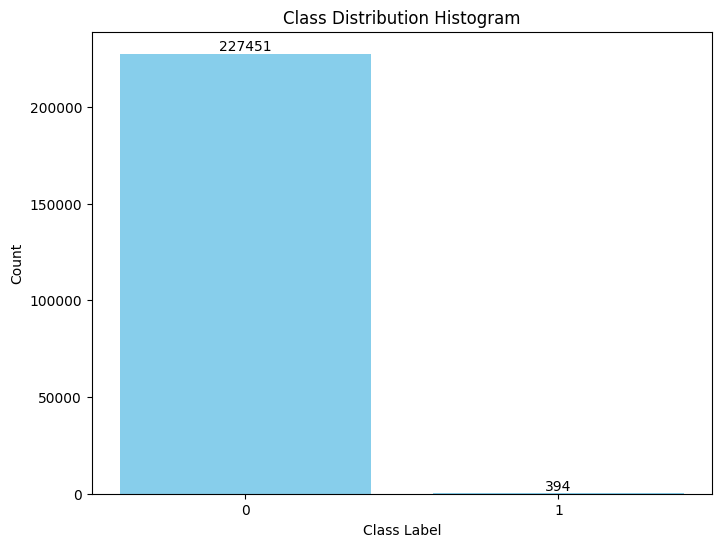

In [ ]:
plot_class_distribution(y_train)

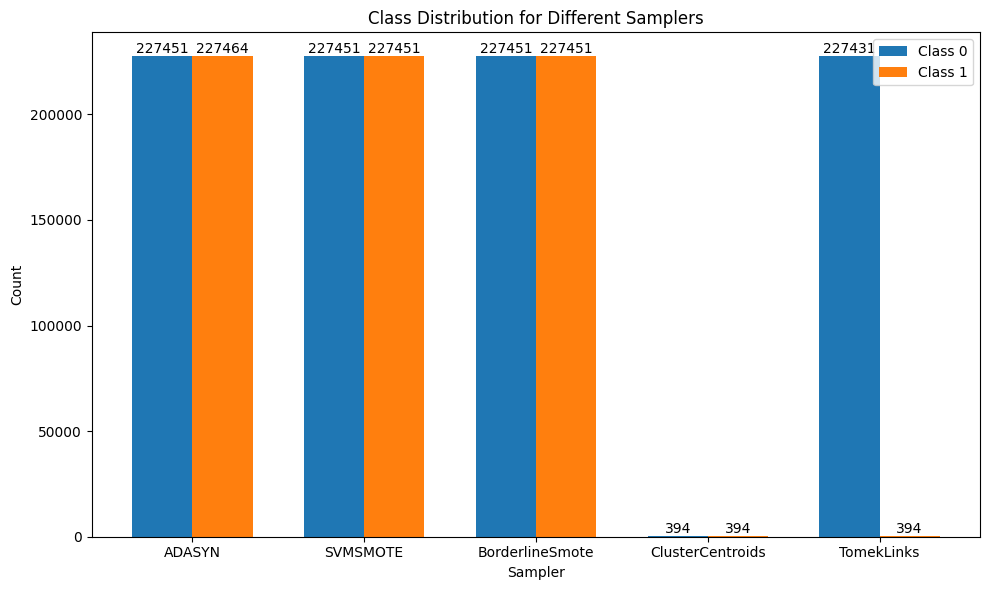

In [ ]:
data_distribution_all_samplers(resampled_data)

## Fitting Model

In [ ]:
import xgboost as xgb
from sklearn import metrics
import matplotlib.pyplot as plt
from pipeline_utils import save_report
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, matthews_corrcoef


In [ ]:
f1_scores = {}
precision_scores = {}
recall_scores = {}


for key in resampled_data.keys():
        if key.startswith("X_resampled_"):  # Check if it is an X_resampled_ key
          sampler = key.replace("X_resampled_", "")  # Get the original sampler_name

          # Get the resampled X and y for the current sampler
          X_resampled = resampled_data[f'X_resampled_{sampler}']
          y_resampled = resampled_data[f'y_resampled_{sampler}']
          X_test = resampled_data['X_test']
          y_test = resampled_data['y_test']

          model = xgb.XGBClassifier(random_state=42)




          print("Fitting The Model")

          # Fit classifier on the resampled data
          model.fit(X_resampled, y_resampled)

          # Make predictions on the test set
          y_test_pred = model.predict(X_test)


          y_true = y_test
          y_pred = y_test_pred


          #recall score
          recall= recall_score(y_true, y_pred)
          print ('\t recall score =', recall)
          recall_scores[sampler] = recall

          #precision score
          precision = precision_score(y_true, y_pred)
          precision_scores[sampler] = precision

          #accuracy score
          accuracy= accuracy_score(y_true, y_pred)

          #MCC
          MCC = matthews_corrcoef(y_true, y_pred)

          # Compute False postive rate, and True positive rate
          fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
          # Calculate Area under the curve to display on the plot
          auc= metrics.auc(fpr, tpr)
          # Now, plot the computed values



          #classification report
          report = classification_report_imbalanced(y_true, y_pred, output_dict=True)
          f1_scores[sampler] = report[1]['f1']
          df_report = pd.DataFrame(report)
          df_report['Accuracy'] = pd.Series(accuracy, index=df_report.index)
          df_report['AUC'] = pd.Series(auc, index=df_report.index)
          df_report['MCC'] = pd.Series(MCC, index=df_report.index)
          print(df_report)


          #confusion Matrix
          cm = confusion_matrix(y_true, y_pred)
          df_cm = pd.DataFrame(cm)
          print(df_cm)
          print("="*50)
          print("\n")

          save_report(f"XGB_NB2_{sampler}_20F", df_report, "_CR")
          save_report(f"XGB_NB2_{sampler}_20F", df_cm, "__CM")

Fitting The Model
	 recall score = 0.8469387755102041
                0          1   avg_pre   avg_rec   avg_spe    avg_f1  avg_geo  \
pre      0.999736   0.703390  0.999226  0.999122  0.847201  0.999163  0.92001   
rec      0.999384   0.846939  0.999226  0.999122  0.847201  0.999163  0.92001   
spe      0.846939   0.999384  0.999226  0.999122  0.847201  0.999163  0.92001   
f1       0.999560   0.768519  0.999226  0.999122  0.847201  0.999163  0.92001   
geo      0.920010   0.920010  0.999226  0.999122  0.847201  0.999163  0.92001   
iba      0.859321   0.833514  0.999226  0.999122  0.847201  0.999163  0.92001   
sup  56864.000000  98.000000  0.999226  0.999122  0.847201  0.999163  0.92001   

      avg_iba  total_support  Accuracy       AUC       MCC  
pre  0.859276          56962  0.999122  0.978674  0.771409  
rec  0.859276          56962  0.999122  0.978674  0.771409  
spe  0.859276          56962  0.999122  0.978674  0.771409  
f1   0.859276          56962  0.999122  0.978674  0.7

## Plotting

<ipython-input-25-3cc0f98cb1e1>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


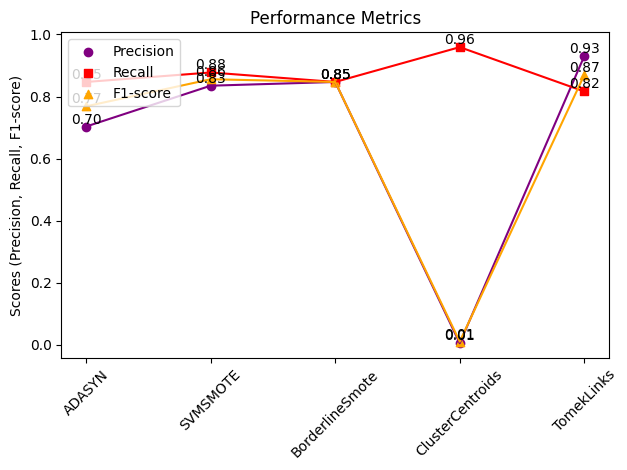

In [ ]:
import matplotlib.pyplot as plt


# Create a figure and axis
fig, ax = plt.subplots()



# Create Scatter Plots for Precision, Recall, and F1-score on the left axis
precision_scatter = ax.scatter(precision_scores.keys(), precision_scores.values(), color='purple', marker='o', label='Precision')
recall_scatter = ax.scatter(recall_scores.keys(), recall_scores.values(), color='red', marker='s', label='Recall')
f1_scatter = ax.scatter(f1_scores.keys(), f1_scores.values(), color='orange', marker='^', label='F1-score')
ax.set_ylabel('Scores (Precision, Recall, F1-score)', color='black')

# Connect the scatter points with line plots
ax.plot(precision_scores.keys(), precision_scores.values(), color='purple', linestyle='solid')
ax.plot(recall_scores.keys(), recall_scores.values(), color='red', linestyle='solid')
ax.plot(f1_scores.keys(), f1_scores.values(), color='orange', linestyle='solid')



lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

# Add title
plt.title('Performance Metrics')

# Rotate x-axis labels for better visibility
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


# Add text labels to the scatter points for precision, recall, and F1-score
for scatter, scores in zip([precision_scatter, recall_scatter, f1_scatter], [precision_scores, recall_scores, f1_scores]):
    for clf, value in scores.items():
        ax.text(clf, value, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

# Adjust layout and save the plot
fig.tight_layout()
plt.savefig('performance_metrics_plot_nb2.png')

# Show the plot
plt.show()
